In [168]:
import numpy as np

import pandas as pd

import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn import linear_model

#convenient for running multiple linear regression with few lines of code
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
%matplotlib inline

## Import Movie data

In [169]:
data = pd.read_csv("allData.tsv", sep='\t')
df_ratings = pd.read_csv('ratings.csv')
data.head()

,userID,age,gender,movieID,name,year,genre1,genre2,genre3,rating
0,747,1,F,1193,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,5
1,747,1,F,661,James and the Giant Peach,1996,Animation,Children's,Musical,3
2,747,1,F,2804,"Christmas Story, A",1983,Comedy,Drama,NaN,5
3,747,1,F,919,"Wizard of Oz, The",1939,Adventure,Children's,Drama,4
4,747,1,F,2791,Airplane!,1980,Comedy,NaN,NaN,4


In [141]:
data.dtypes

userID      int64
age         int64
gender     object
movieID     int64
name       object
year        int64
genre1     object
genre2     object
genre3     object
rating      int64
dtype: object

## Handle categorical and missing data

In [5]:
# change NaN to 0
data[['gender', 'genre1', 'genre2', 'genre3']] = data[['gender', 'genre1', 'genre2', 'genre3']].fillna(0)
#data.head()

In [6]:
# convert to categorical columns
data["gender"] = data["gender"].astype('category')
data["genre1"] = data["genre1"].astype('category')
data["genre2"] = data["genre2"].astype('category')
data["genre3"] = data["genre3"].astype('category')

#data.dtypes

In [7]:
cat_columns = data.select_dtypes(['category']).columns
#cat_columns

In [8]:
map_gender = dict( enumerate(data['gender'].cat.categories) )
map_genre1 = dict( enumerate(data['genre1'].cat.categories) )
map_genre2 = dict( enumerate(data['genre2'].cat.categories) )
map_genre3 = dict( enumerate(data['genre3'].cat.categories) )

#print(map_genre2)

In [9]:
#data[cat_columns]
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
#data.head()

In [ ]:
movie_data.head()

In [10]:
new_df =  data
new_df.describe()

,userID,age,gender,movieID,year,genre1,genre2,genre3,rating
count,31620.000000,31620.000000,31620.000000,31620.000000,31620.000000,31620.000000,31620.000000,31620.000000,31620.000000
mean,2971.801834,29.232543,0.764611,1899.408539,1985.426850,3.844402,6.394845,3.558887,3.575142
std,1712.423189,11.842979,0.424248,1060.151704,15.399585,3.370557,5.796635,5.329853,1.116827
min,4.000000,1.000000,0.000000,1.000000,1926.000000,0.000000,0.000000,0.000000,1.000000
25%,1399.000000,25.000000,1.000000,1097.000000,1980.000000,0.000000,0.000000,0.000000,3.000000
50%,2998.000000,25.000000,1.000000,2011.000000,1990.000000,4.000000,5.000000,0.000000,4.000000
75%,4394.000000,35.000000,1.000000,2772.000000,1997.000000,7.000000,13.000000,9.000000,4.000000
max,6038.000000,56.000000,1.000000,3952.000000,2000.000000,16.000000,17.000000,15.000000,5.000000


In [11]:
#create a data frame with the average rating for each movie...using title instead of ids for better description
ratings =  pd.DataFrame(new_df.groupby('name')['rating'].mean())
ratings['number_of_ratings'] = new_df.groupby('name')['rating'].count()
ratings.head()

,rating,number_of_ratings
name,,
'Til There Was You,3.000000,1
"'burbs, The",2.850467,107
...And Justice for All,3.750000,4
10 Things I Hate About You,3.000000,1
101 Dalmatians,3.434783,23


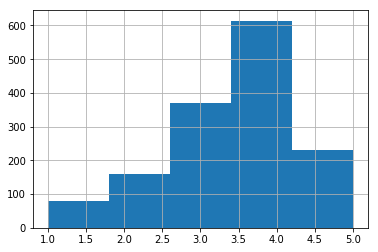

In [12]:
#take a look at the distribution of ratings
import matplotlib.pyplot as plt
ratings['rating'].hist(bins=5)

Most of the movies are rated between 2.5 and 5
It's fair to say that, most movies have large enough ratings. Also the most highly rated movies tend to be wuite famous.

We'll check this number ratings and rating score below.

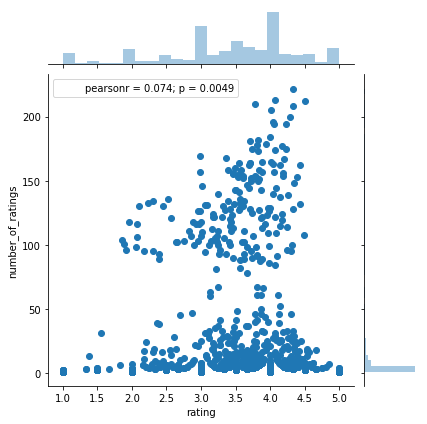

In [13]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

Clearly, there is a positive relationship between the number of ratings of a movie and the rating score.

We now create the matrices necessary for matrix factorization.

In [19]:
movie_matrix = new_df.pivot_table(index='userID', columns='name', values='rating', fill_value=0).reset_index()
movie_matrix.columns

Index(['userID', ''Til There Was You ', ''burbs, The ',
       '...And Justice for All ', '10 Things I Hate About You ',
       '101 Dalmatians ', '13th Warrior, The ', '187 ',
       '2 Days in the Valley ', '20 Dates ',
       ...
       'X-Men ', 'Yards, The ', 'Yellow Submarine ', 'Yojimbo ',
       'You've Got Mail ', 'Young Frankenstein ', 'Young Sherlock Holmes ',
       'Zero Effect ', 'Zeus and Roxanne ', 'eXistenZ '],
      dtype='object', name='name', length=1454)

In [20]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
name,,
Star Wars: Episode V - The Empire Strikes Back,4.324324,222
Terminator 2: Judgment Day,4.065728,213
Star Wars: Episode IV - A New Hope,4.509434,212
Jurassic Park,3.780952,210
"Silence of the Lambs, The",4.326923,208
Back to the Future,4.014634,205
"Matrix, The",4.285000,200
E.T. the Extra-Terrestrial,4.040816,196
L.A. Confidential,4.226804,194


In [21]:
sw_user_rating = movie_matrix['Star Wars: Episode V - The Empire Strikes Back ']
termination_user_rating = movie_matrix['Terminator 2: Judgment Day ']
sw_user_rating.head()
termination_user_rating.head()

0    0
1    0
2    0
3    0
4    0
Name: Terminator 2: Judgment Day , dtype: int64

In [22]:
#using a basic similarity score...correlation
similar_to_sw = movie_matrix.corrwith(sw_user_rating)
similar_to_termination = movie_matrix.corrwith(termination_user_rating)
similar_to_sw.sort_values(ascending=False).head(10)

name
Star Wars: Episode V - The Empire Strikes Back     1.000000
Star Wars: Episode IV - A New Hope                 0.822626
Matrix, The                                        0.750026
Terminator 2: Judgment Day                         0.706137
E.T. the Extra-Terrestrial                         0.694579
Jurassic Park                                      0.692801
Back to the Future                                 0.687102
Silence of the Lambs, The                          0.663087
Gladiator                                          0.573848
Wizard of Oz, The                                  0.573238
dtype: float64

In [23]:
similar_to_termination.sort_values(ascending=False).head(10)

name
Terminator 2: Judgment Day                         1.000000
Matrix, The                                        0.771600
Star Wars: Episode V - The Empire Strikes Back     0.706137
Star Wars: Episode IV - A New Hope                 0.695154
Jurassic Park                                      0.692692
Silence of the Lambs, The                          0.669519
Back to the Future                                 0.657422
E.T. the Extra-Terrestrial                         0.612994
Abyss, The                                         0.605068
Gladiator                                          0.572536
dtype: float64

That's quite some good results, we will improve this implementing the MF methods

In [26]:
movie_matrix.head()

name,userID,'Til There Was You,"'burbs, The",...And Justice for All,10 Things I Hate About You,101 Dalmatians,"13th Warrior, The",187,2 Days in the Valley,20 Dates,...,X-Men,"Yards, The",Yellow Submarine,Yojimbo,You've Got Mail,Young Frankenstein,Young Sherlock Holmes,Zero Effect,Zeus and Roxanne,eXistenZ
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy
 
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        
        for i in range(len(R)):
            
            for j in range(len(R[i])):
                
                if R[i][j] > 0:
                    
                    eij = R[i][j] - numpy.dot(P[i,:],Q[:,j])
                    
                    for k in range(K):
                        
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = numpy.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - numpy.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        if e < 0.001:
            break
    return P, Q.T


In [ ]:
#R = movie_matrix #
R = [[5,3,0,1],[4,0,0,1],[1,1,0,5],[1,0,0,4],[0,1,5,4],]
    
R = numpy.array(R)

N = len(R)

M = len(R[0])

K = 2

P = numpy.random.rand(N,K)

Q = numpy.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K)

nR = numpy.dot(nP, nQ.T)


### Collaborative Filtering Implementation

##### There are two approaches

##### 1. Memory based approach: 
This can be divided into two, (i) user-item filtering and (ii) item-item filtering.

In this, we basically calculate the closest the user or item using the Cosine similarity or Pearson correlation coefficients

The cosine similarity for two users is computed as:

$sim(u, u^{'}) = cos(\theta) = \frac{r_u.r_{u^{'}}}{||r_u||||r_{u^{'}}} = \sum_i \frac{r_{ui}r_{u^{'}i}}{\sqrt{\sum_ir_{ui}^2}\sqrt{\sum_ir_{u^{'}i}^2}}$

Here $u$ and $u^{'}$ represents two different users.

We can predict user-u’s rating for movie-i by taking weighted sum of movie-i ratings from all other users (u′s) where weighting is similarity number between each user and user-u.

We now predict a users rating as follows:

#### $\hat{r_{ui}} = \frac{\sum_{u^{'}} sim(u, u^{'})r_{u^{'}i}}{\sum_{u^{'}} |sim(u, u^{'})|}$

Drawback:  its performance decreases when we have sparse data which hinders scalability of this approach for most of the real-world problems.

#### Implementation

In [178]:
tp = list(df_ratings["movieID"])
tp[1] = 9

if 9 in tp:
    ind = tp.index(9)
    print(ind)
    tp[ind]=0
    print(tp[1])

df_ratings.movieID.unique().shape[0]


1
0


1465

In [179]:
from itertools import cycle
n_users = df_ratings.userID.unique().shape[0]
n_movies = df_ratings.movieID.unique().shape[0]

l_users = cycle(list(range(n_users)))
l_movies = list(range(n_movies))
df_ratings['user_id'] = df_ratings['userID'].astype("int")
df_ratings['movie_id'] = df_ratings['movieID'].astype("int")
df_ratings['movieID'] = df_ratings['movieID'].astype("int")
#df_ratings['movie_id2'] = df_ratings['movie_id'].astype("str")
current_idm = 1
current_idu = 747
indm = 1
indu = 1
listMID = list(df_ratings["movieID"])
for idx, row in df_ratings.iterrows():
    new_idm = int(df_ratings.loc[idx, 'movieID'])
    #intialize the  foudn movie id in list
    foundm = False
    for k in range(1465):
        if new_idm in listMID:
            #get the index
            lind = listMID.index(new_idm)
            #update the movie_id
            df_ratings.loc[lind, 'movie_id'] = indm
            #now set that list item to zero
            listMID[lind]=0
            foundm = True
        else:
            #break and fetch a new row
            break
    #increment the indicator
    if foundm:
        indm+=1
    #current_idm = new_idm
    
    #there is a bit of logic problem here...
    if new_idu==current_idu:
        df_ratings.loc[idx, 'user_id'] = indu
    else:
        indu+=1
        current_idu = new_idu
        df_ratings.loc[idx, 'user_id'] = indu
        
df_ratings
print(str(n_users) + ' users')
print(str(n_movies) + ' movies')

2353 users
1465 movies


In [199]:
df_ratings

,userID,movieID,rating,user_id,movie_id
0,747,1193,5,2,1
1,747,661,3,2,2
2,747,2804,5,2,3
3,747,919,4,2,4
4,747,2791,4,2,5
5,747,2797,4,2,6
6,747,720,3,2,7
7,747,1270,5,2,8
8,747,1097,4,2,9
9,747,588,4,2,10


In [218]:
## construct a user item matrix
m_ratings = np.zeros((n_users, n_movies))
for row in df_ratings.itertuples():
    #row[3] will be user rating row[4] user_id and row[5] movie_id  
    m_ratings[row[4]-1, row[5]-1] = row[3]

0

In [198]:
#examine the sparsity of the matrix
sparsity = float(len(m_ratings.nonzero()[0]))
print(sparsity)
sparsity /= (m_ratings.shape[0] * m_ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

1465.0
Sparsity: 0.04%


The sparsity is pretty bad! Some users have not rated some movies. A pipeline that checks that and uses a different predictin model will be fine.

In [256]:
#split into training and testing
def train_test_split(m_ratings):
    test = np.zeros(m_ratings.shape)
    train = m_ratings.copy()
    for user in range(m_ratings.shape[0]):
        #checking for xero ratings
        #confirm with tobias, if user rated less than say k-movies, move to a different pipeline
        if np.count_nonzero(m_ratings[user,:])<20:
            continue
        test_ratings = np.random.choice(m_ratings[user, :].nonzero()[0], size=10, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = m_ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [259]:
train, test = train_test_split(m_ratings)
np.count_nonzero(train)

1455

In [267]:
#compute the similarity
def fast_similarity(m_ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = m_ratings.dot(m_ratings.T) + epsilon
    elif kind == 'item':
        sim = m_ratings.T.dot(m_ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [270]:
#train the model
fast_similarity(train, kind='user')

array([[  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  2.30675751e-07,   1.00000000e+00,   2.30675751e-07, ...,
          2.30675751e-07,   2.30675751e-07,   2.30675751e-07],
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       ..., 
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]])

In [273]:
#get the similarity score
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
item_similarity
user_similarity
#print(item_similarity[:10, :4])

array([[  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  2.30675751e-07,   1.00000000e+00,   2.30675751e-07, ...,
          2.30675751e-07,   2.30675751e-07,   2.30675751e-07],
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       ..., 
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   2.30675751e-07,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]])

In [262]:
#prediction model
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [274]:
#we wll now use the similarity matrix to make some predictions
print(predict_fast_simple(train, user_similarity, kind='user'))

[[  4.90382124e-10   3.92305699e-10   3.92305699e-10 ...,   9.80764247e-11
    9.80764247e-11   9.80764247e-11]
 [  4.99728872e+00   3.99783098e+00   3.99783098e+00 ...,   9.99457745e-01
    9.99457745e-01   9.99457745e-01]
 [  4.90382124e-10   3.92305699e-10   3.92305699e-10 ...,   9.80764247e-11
    9.80764247e-11   9.80764247e-11]
 ..., 
 [  4.90382124e-10   3.92305699e-10   3.92305699e-10 ...,   9.80764247e-11
    9.80764247e-11   9.80764247e-11]
 [  4.90382124e-10   3.92305699e-10   3.92305699e-10 ...,   9.80764247e-11
    9.80764247e-11   9.80764247e-11]
 [  4.90382124e-10   3.92305699e-10   3.92305699e-10 ...,   9.80764247e-11
    9.80764247e-11   9.80764247e-11]]


In [277]:
#validate the prediction accuracy using the scikit learn mse metric
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ',str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ', str(get_mse(item_prediction, test)))

User-based CF MSE:  15.6
Item-based CF MSE:  15.5651116671


The prediction error is quite high! There is no real difference between the user based similarity prediction and the item based similarity prediction.

### Top $k$ collaborative filtering.
We will try to improve the test error by considering only the top k users who are most similar to the input user.

In [283]:
#this is quite slow but will work okay
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [284]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ', str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ', str(get_mse(pred, test)))

Top-k User-based CF MSE:  15.6
Top-k Item-based CF MSE:  15.5992790781


This is a little worse. Tuning the parameter k.

In [287]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  
    

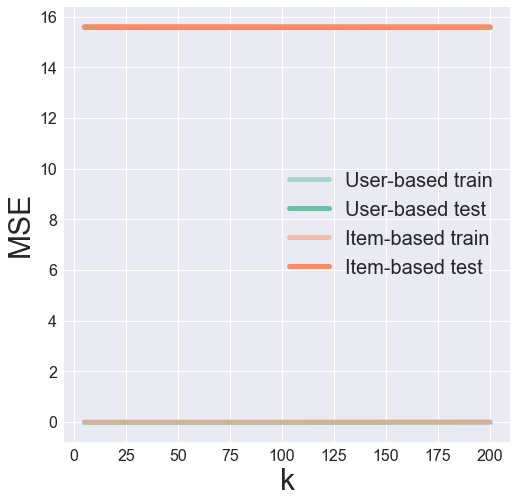

In [288]:
#plot the estimates
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);